# SD-TSIA211 -- TP SGD

```yaml
Name: Liyao JIAO
Date: Feb 13 2024
```

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tqdm import tqdm
from typing import List, Any
from dataclasses import dataclass

2024-02-13 14:31:05.493186: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 14:31:05.495156: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-13 14:31:05.521048: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 14:31:05.521071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 14:31:05.521731: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [4]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]
x_test = test_data[0].reshape(-1,784).astype(float) / 255
y_test = test_data[1]

In [5]:
np.random.seed(42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True)
# y_train, y_val = train_test_split(y_train, test_size=0.1, shuffle=True)


In [6]:
print(len(x_train), len(x_val), len(x_test))

54000 6000 10000


In [7]:
# source: https://keras.io/guides/training_with_built_in_methods/

inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
x = layers.Dense(32, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation=None, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#def loss(true, pred):
#    val = 0.
#    for i in range(len(true)):
#        val -= np.log(pred[i, true[i]])
#    return val / len(true)
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 predictions (Dense)         (None, 10)                330       
                                                                 
Total params: 26506 (103.54 KB)
Trainable params: 26506 (103.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-02-13 14:31:07.565860: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 14:31:07.566180: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Question 4.1

How many optimization variables are we going to train using this model?

- **26506 trainable params**

---

In [8]:
# untrained model
logits = model(x_train)
np.argmax(logits, 1)[0:100]

array([4, 1, 1, 4, 4, 4, 4, 4, 1, 9, 4, 9, 4, 9, 1, 9, 4, 4, 9, 1, 4, 4,
       1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 3, 4, 9, 4, 4, 9, 4,
       4, 4, 4, 1, 1, 4, 4, 4, 9, 1, 3, 1, 4, 9, 9, 4, 4, 1, 4, 3, 4, 4,
       4, 1, 9, 1, 1, 4, 1, 1, 4, 9, 1, 9, 4, 4, 1, 9, 9, 1, 4, 1, 4, 4,
       4, 1, 1, 4, 4, 1, 4, 4, 4, 4, 1, 4])

In [9]:
# what we would like to get
y_train[0:100]

array([1, 6, 6, 7, 8, 4, 2, 7, 7, 6, 7, 3, 6, 9, 6, 1, 2, 1, 1, 0, 6, 3,
       0, 5, 3, 9, 2, 4, 1, 3, 3, 8, 7, 2, 0, 8, 5, 2, 5, 5, 6, 1, 1, 2,
       2, 7, 6, 6, 4, 2, 1, 1, 7, 2, 0, 4, 9, 4, 6, 5, 9, 2, 3, 0, 0, 0,
       6, 4, 1, 6, 2, 9, 4, 3, 3, 9, 7, 8, 9, 5, 3, 4, 4, 6, 1, 2, 9, 4,
       5, 6, 3, 1, 9, 4, 0, 9, 0, 3, 3, 4], dtype=uint8)

In [10]:
## Computing a stochastic gradient

# Source: https://keras.io/guides/writing_a_training_loop_from_scratch/

# Example of gradient computation using automatic differentiation

x_train_batch = x_train[:8]
y_train_batch = y_train[:8]
with tf.GradientTape() as tape:
    # Run the forward pass of the layer.
    # The operations that the layer applies
    # to its inputs are going to be recorded
    # on the GradientTape.
    logits = model(x_train_batch)  # Logits for this minibatch

    # Compute the loss value for this minibatch.
    loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

## Updating weights

def update_weights(model, update):
    new_weights = model.trainable_weights.copy()
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + update[i]
    model.set_weights(new_weights)
    

## Evaluate model
samples_for_evaluation = np.random.randint(0, 10000, 1000)
logits = model(x_train[samples_for_evaluation])
loss(y_train[samples_for_evaluation], logits).numpy()
    

2.407624

In [11]:
@dataclass
class TrainingOutput:
    train_losses: List[float]
    val_losses: List[float]
    best_epoch: int
    best_weights: Any
    

In [29]:
def training(model, X, y, epochs=1000, alpha=1e-3, batch_size=128, start_epoch=0, top_one=True):
    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    best_weights = None
    best_epoch = None
    for epoch in range(start_epoch, start_epoch + epochs):
        train_loss = 0
        for i in tqdm(range(0, X.shape[0], batch_size)):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            with tf.GradientTape() as tape:
            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
                logits = model(X_batch)  # Logits for this minibatch

                # Compute the loss value for this minibatch.
                loss_value = loss(y_batch, logits)

            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grad = tape.gradient(loss_value, model.trainable_weights)
            update_weights(model,  [-alpha * g for g in grad])
            train_loss += loss_value.numpy() * len(X_batch)
        

        logits = model(x_val)
        val_loss = loss(y_val, logits).numpy()
        train_losses.append(train_loss / len(X))
        val_losses.append(val_loss)
        print(f"Epoch {epoch}: train_loss = {train_loss / len(X)}, val_loss = {val_loss}")

        if top_one:
            if val_loss < best_val_loss:
                best_weights = model.get_weights()
                best_epoch = epoch
            else:
                pass
        

    return TrainingOutput(train_losses, val_losses, best_epoch, best_weights)


In [13]:
res = training(model, x_train,y_train, epochs=10, alpha=5e-2, batch_size=128, start_epoch=0)

  0%|          | 0/422 [00:00<?, ?it/s]

100%|██████████| 422/422 [00:02<00:00, 192.18it/s]


Epoch 0: train_loss = 0.6800173704006054, val_loss = 0.3518930673599243


100%|██████████| 422/422 [00:02<00:00, 194.28it/s]


Epoch 1: train_loss = 0.3232289146317376, val_loss = 0.2897440493106842


100%|██████████| 422/422 [00:02<00:00, 195.95it/s]


Epoch 2: train_loss = 0.27505827452959836, val_loss = 0.2541773319244385


100%|██████████| 422/422 [00:02<00:00, 191.45it/s]


Epoch 3: train_loss = 0.242585478760578, val_loss = 0.22775286436080933


100%|██████████| 422/422 [00:02<00:00, 193.06it/s]


Epoch 4: train_loss = 0.21832664119314266, val_loss = 0.20798085629940033


100%|██████████| 422/422 [00:02<00:00, 193.59it/s]


Epoch 5: train_loss = 0.1991608843582648, val_loss = 0.19227451086044312


100%|██████████| 422/422 [00:02<00:00, 196.82it/s]


Epoch 6: train_loss = 0.18359042235657022, val_loss = 0.1796051412820816


100%|██████████| 422/422 [00:02<00:00, 193.63it/s]


Epoch 7: train_loss = 0.17067454367655294, val_loss = 0.16894228756427765


100%|██████████| 422/422 [00:02<00:00, 197.38it/s]


Epoch 8: train_loss = 0.15985914411368193, val_loss = 0.1600930243730545


100%|██████████| 422/422 [00:02<00:00, 196.97it/s]

Epoch 9: train_loss = 0.1503453015839612, val_loss = 0.15278393030166626


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


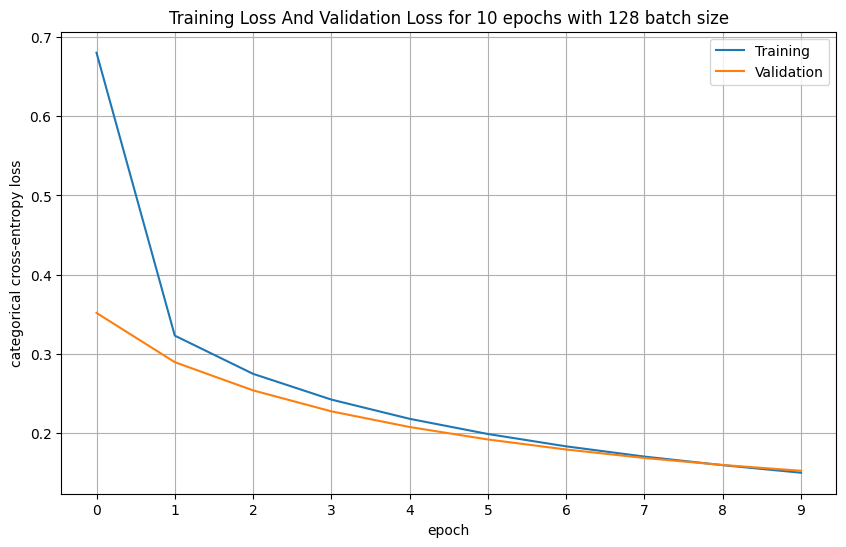

In [27]:
fig = plt.figure(figsize=(10, 6))
epochs = range(10)

plt.plot(epochs, res.train_losses)
plt.plot(epochs, res.val_losses)

plt.legend()

plt.title("Training Loss And Validation Loss for 10 epochs with 128 batch size")
plt.legend(["Training", "Validation"])

plt.xlabel("epoch")
plt.ylabel("categorical cross-entropy loss")
plt.xticks(range(10))
plt.grid()

## Question 5 & Question 6

**According to you, what is the advantage of such a scheme?**

There is no need to compute gradients for all samples. Computation is fast, and convergence is fast too.

## Question 7

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [28]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]
x_test = test_data[0].reshape(-1,784).astype(float) / 255
y_test = test_data[1]

In [42]:
y_train_hat = np.argmax(model(x_train), axis=1)

y_test_hat = np.argmax(model(x_test), axis=1)

In [33]:
len(y_train_hat)

60000

Text(0.5, 1.0, 'CM on Training Set')

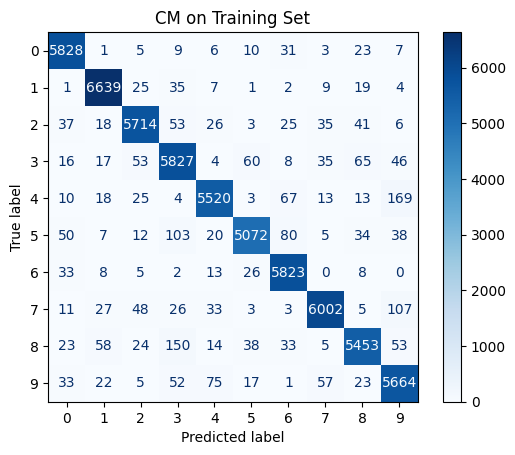

In [45]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_hat, cmap=plt.cm.Blues)

plt.title("CM on Training Set")

Text(0.5, 1.0, 'CM on Test Set')

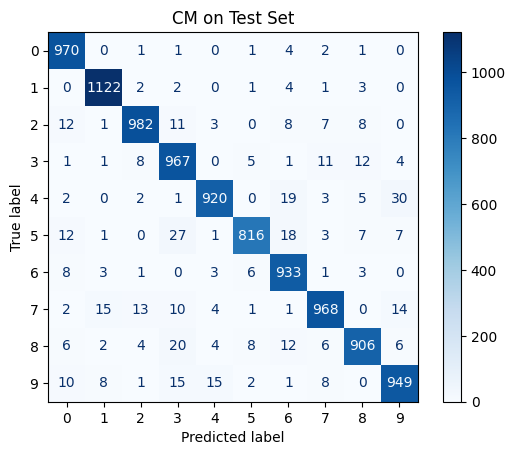

In [46]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat, cmap=plt.cm.Blues)

plt.title("CM on Test Set")

In [40]:
print(classification_report(y_train, y_train_hat))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5923
           1       0.97      0.98      0.98      6742
           2       0.97      0.96      0.96      5958
           3       0.93      0.95      0.94      6131
           4       0.97      0.94      0.96      5842
           5       0.97      0.94      0.95      5421
           6       0.96      0.98      0.97      5918
           7       0.97      0.96      0.97      6265
           8       0.96      0.93      0.95      5851
           9       0.93      0.95      0.94      5949

    accuracy                           0.96     60000
   macro avg       0.96      0.96      0.96     60000
weighted avg       0.96      0.96      0.96     60000



In [47]:
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.92      0.96      0.94      1010
           4       0.97      0.94      0.95       982
           5       0.97      0.91      0.94       892
           6       0.93      0.97      0.95       958
           7       0.96      0.94      0.95      1028
           8       0.96      0.93      0.94       974
           9       0.94      0.94      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



For this model trained 10 epochs with batch_size 128, the average precision on Training set is 96% and on Test set is 95%.

---
---